In [1]:
import numpy as np
# plot window size
PLOT_PARAM = {"xmin": 0, "xmax": 2.25, "ymin": -2.0,"ymax":2.0}
# contour levels
D = np.linspace(-0.225,0.0,11)

# Double Null

## NSTX Run Double Null Divertor

#### Solution Setup

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from utils.gs_solovev_sol import GS_Linear
# tokamak = GS_Linear(A=-0.155, eps= 2/6.2, kappa=1.6, delta=0.4)
NSTX = GS_Linear(A=0.0, eps = 0.67/0.86,kappa = 2.0,delta = 0.35,divertor=2)

In [3]:
# make mesh
nx = 501
ny = 501
zoom = 0.25
inner_point = (1 - NSTX.eps*(1+zoom))
outer_point = (1 + NSTX.eps*(1+zoom))


high_point  = (1.1)*NSTX.kappa*NSTX.eps 
low_point   = -(1.1)*NSTX.kappa*NSTX.eps

x, y = np.meshgrid(
                np.linspace(outer_point, inner_point, nx),
    np.linspace(low_point, 
                high_point, ny),
)

X = np.vstack((np.ravel(x), np.ravel(y))).T

# Normalize and skew to set zero at boundary (Why isn't it zero already?)
psi_true = NSTX.visualize(X,np.shape(x)[0],np.shape(x)[1])



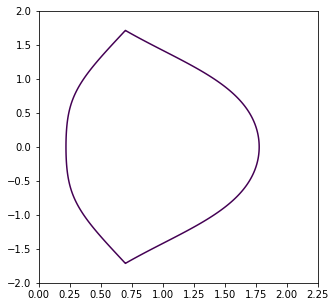

In [4]:
plt.rcParams['figure.dpi'] = 100
fig,ax=plt.subplots(1,1,figsize=(5,5))
c = ax.contour(x, y, psi_true, [0])
ax.axis(xmin=PLOT_PARAM["xmin"],xmax=PLOT_PARAM["xmax"],ymin=PLOT_PARAM["ymin"], ymax=PLOT_PARAM["ymax"])
v = c.collections[0].get_paths()[0].vertices

#### Network Setup

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


Text(0, 0.5, '$\\psi(r,z=0)$')

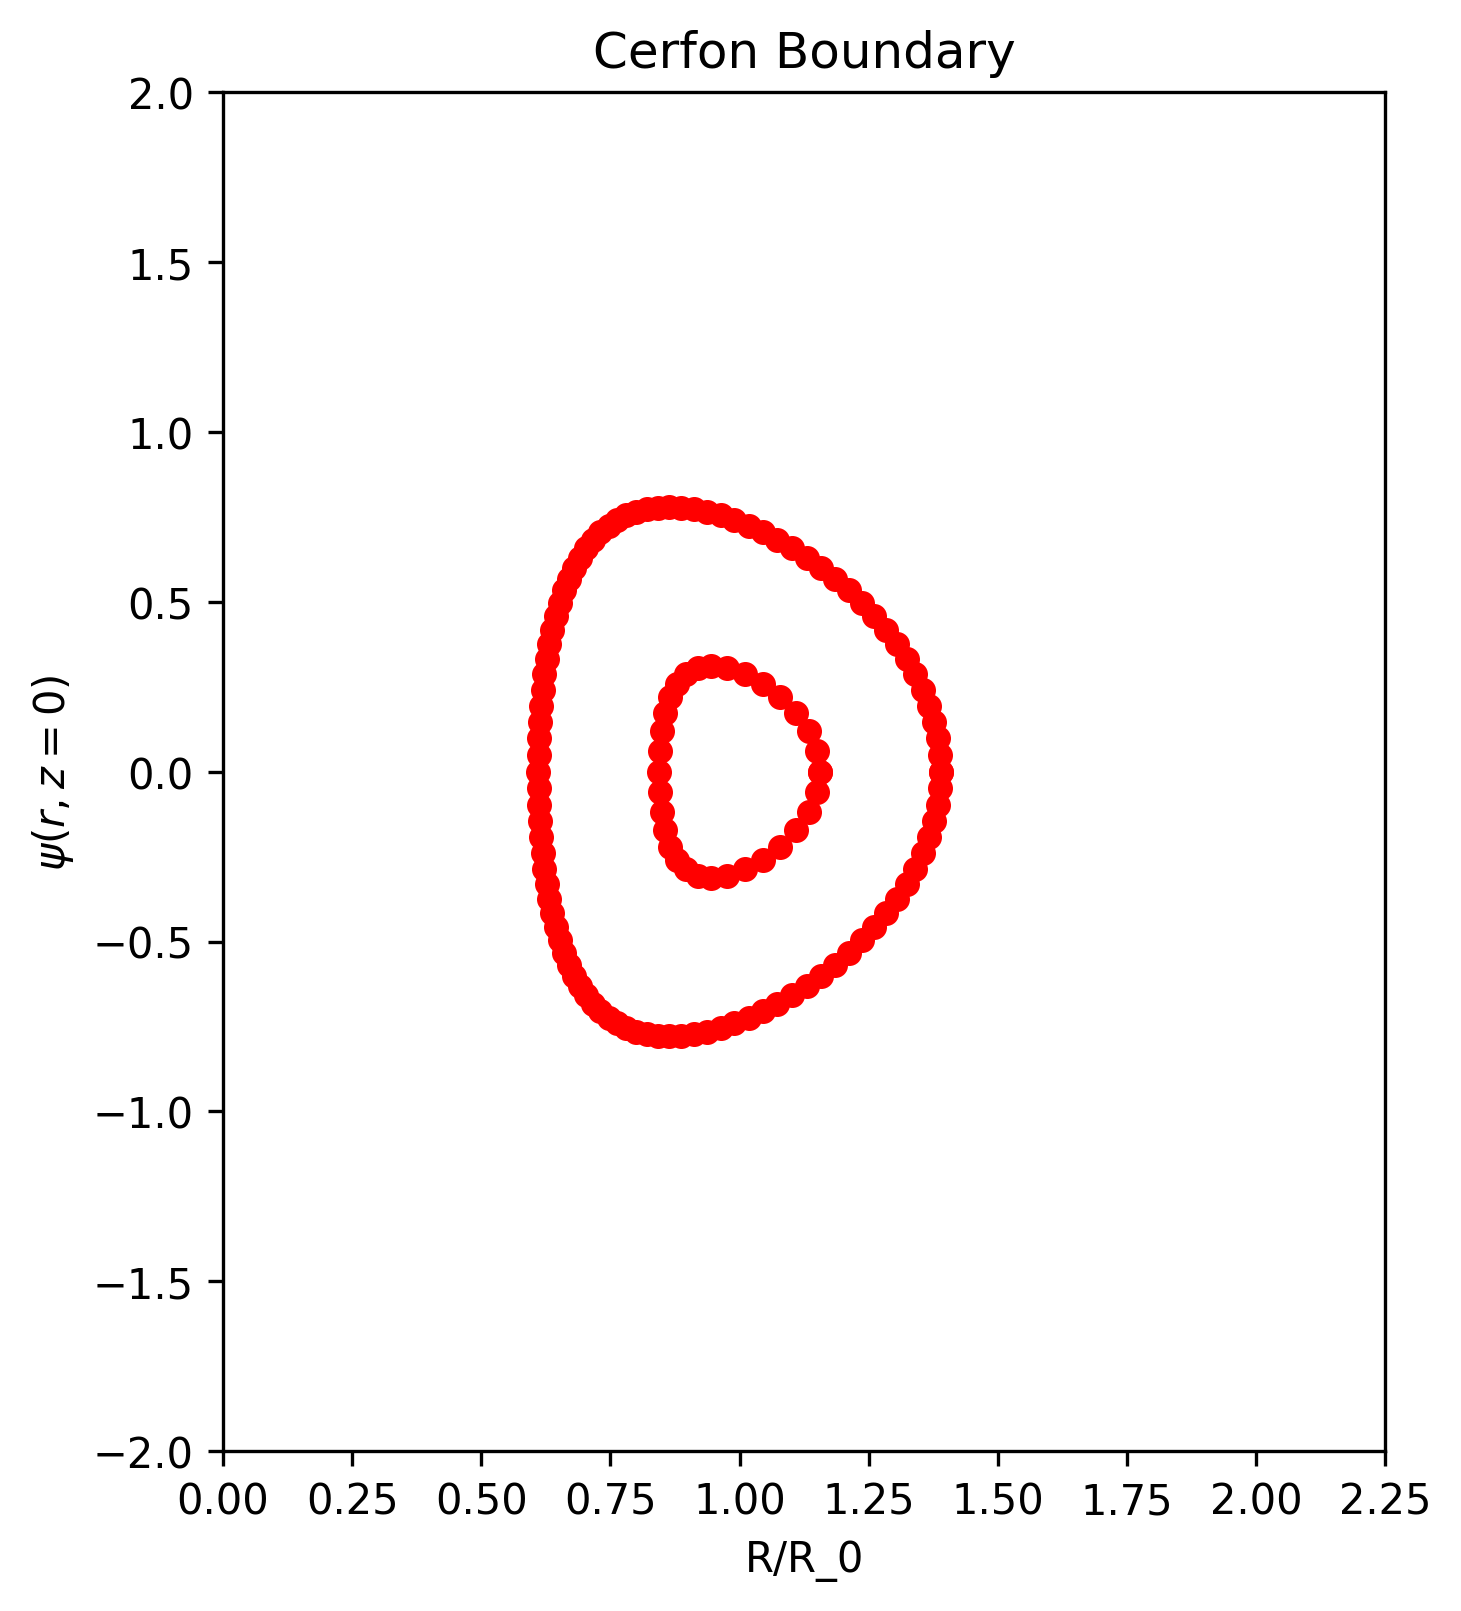

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import deepxde as dde
plt.rcParams['figure.dpi'] = 300

A = 0.0
eps = 0.67/0.86
kappa = 2.0
delta = 0.35

N1 = - (1 + np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N2 = (1 - np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N3 = - kappa / (eps * np.cos(np.arcsin(delta)) ** 2)

def gen_traindata(num, size):
    eps = 0.67/0.86*size
    kappa = 2.0
    delta = 0.35
    N = num
    center, eps, kappa, delta = np.array([[0.0,0.0]]), eps, kappa, delta
    # tau_right = np.linspace(-np.pi/16, np.pi/16, N)
    # tau_left = np.linspace(15/16*np.pi,17/16*np.pi,N)
    # tau = np.concatenate((tau_right,tau_left))
    tau = np.linspace(0,2*np.pi,N)
    # Define boundary of ellipse
    x_ellipse = np.asarray([1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)), 
                    eps * kappa * np.sin(tau)]).T
    xvals = x_ellipse
    uvals = np.zeros(len(xvals)).reshape(len(xvals), 1)
    return xvals, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)

def boundary_outer(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 + eps, 0]).all()
def boundary_inner(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - eps, 0]).all()
def boundary_high(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - delta * eps, kappa * eps]).all()
def boundary_low(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - delta * eps, -kappa * eps]).all()
def boundary_high_sep(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - 1.1*delta * eps, 1.1*kappa * eps]).all()
def boundary_low_sep(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - 1.1*delta * eps, -1.1*kappa * eps]).all()


spatial_domain = dde.geometry.Ellipse(eps, kappa, delta,v) 

# x,u = gen_traindata(1001,1.0)

x = v
u = np.zeros(len(x)).reshape(len(x), 1)

n_test = 101
x_test_01,u_test_01 = gen_traindata(n_test,0.5)
x_test_02,u_test_02 = gen_traindata(33, 0.2)
x_test = np.concatenate((x_test_01,x_test_02))
u_test = np.concatenate((u_test_01,u_test_02))

# specify psi, psi_r, psi_z, psi_rr, psi_zz at four locations 

observe_x = np.asarray([[1 + eps, 0], 
                        [1 - eps, 0], 
                        [1 - 1.1*delta * eps, 1.1*kappa * eps],
                        [1 - 1.1* delta * eps, -1.1*kappa * eps]]
                    )
observe_y = np.asarray([0.0, 0.0, 0.0,0.0]).reshape(4, 1)

# observe_x = np.concatenate((x,observe_x))
# observe_y = np.concatenate((u,observe_y))

bc135 = dde.PointSetBC(observe_x,observe_y)
# bc135 = dde.PointSetBC(observe_x, observe_y)

# x[0] = R, x[1] = Z, u[0] = U
bc2 = dde.OperatorBC(spatial_domain ,
                    lambda x, u, _: psi_zz(x, u)+ N1*psi_r(x,u), 
                    boundary_outer)

bc4 = dde.OperatorBC(spatial_domain,
                    lambda x, u, _: psi_zz(x, u)+ N2*psi_r(x,u), 
                    boundary_inner)

# bc7 = dde.OperatorBC(spatial_domain ,lambda x, u, _: psi_rr(x, u)+ N3 * psi_z(x, u), boundary_high)
bc7 =  dde.OperatorBC(spatial_domain ,lambda x, u, _: psi_z(x, u), boundary_high_sep)
bc11 =  dde.OperatorBC(spatial_domain ,lambda x, u, _: psi_z(x, u), boundary_low_sep)

# slope
bc6 = dde.OperatorBC(spatial_domain ,lambda x, u, _: psi_r(x, u), boundary_high_sep)
bc9 = dde.OperatorBC(spatial_domain ,lambda x, u, _: psi_r(x, u), boundary_low_sep)

# Up-down symmetry
bc8 = dde.OperatorBC(spatial_domain, lambda x,u, _: psi_z(x,u), boundary_inner)
bc10 = dde.OperatorBC(spatial_domain, lambda x,u, _: psi_z(x,u), boundary_outer)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    #PDE Loss, fluxloss, outer_curv, inner_curv,high_sep_slop_r,high_sep_slop_z, inner_slop_z, low_sep_slop_r,outer_slop_z,high_sep_slop_z
    [bc135,bc2,bc4,bc6,bc7,bc8,bc9,bc10,bc11], 
    anchors=observe_x,
    num_domain=1024,
    num_boundary=0,
    x_test=x_test, # Just test points in the boundary 
    y_test=u_test,
    train_distribution="LHS"
)

net = dde.maps.FNN([2] + 4 * [40] + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)

# Plot collocation points for visual check
fig,ax=plt.subplots(1, figsize=(5,6))
# ax.scatter(data.train_x_bc[:,0], data.train_x_bc[:,1], s = 25, color='r')
ax.scatter(x_test[:,0], x_test[:,1], s = 25, color='r')
ax.axis(xmin=PLOT_PARAM["xmin"],xmax=PLOT_PARAM["xmax"],ymin=PLOT_PARAM["ymin"], ymax=PLOT_PARAM["ymax"])

ax.set_title('Cerfon Boundary')
ax.set_xlabel(r'R/R_0')
ax.set_ylabel(r'$\psi(r,z=0)$')

Text(0, 0.5, '$\\psi(r,z=0)$')

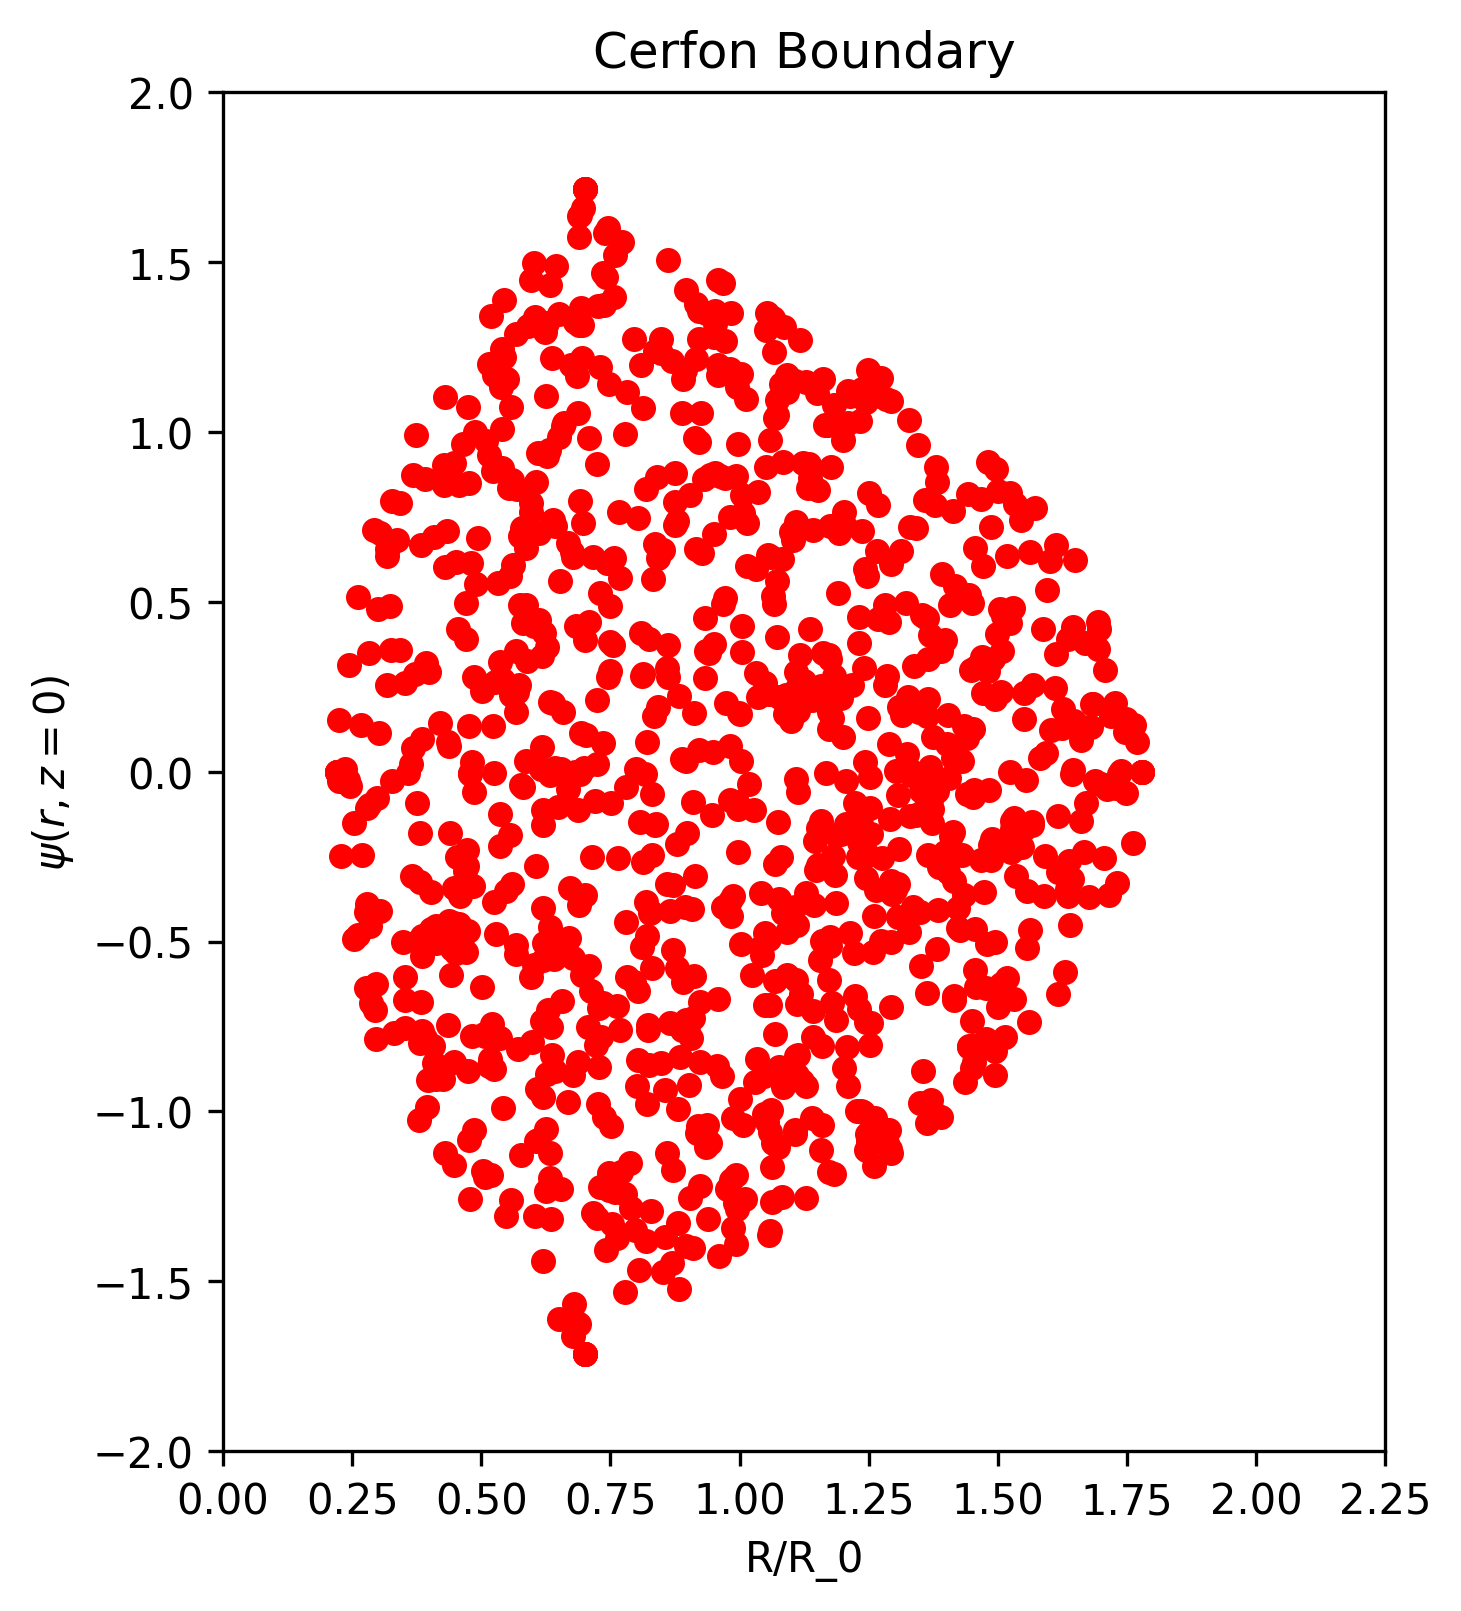

In [6]:
# Plot collocation points for visual check
fig,ax=plt.subplots(1, figsize=(5,6))
ax.scatter(data.train_x[:,0], data.train_x[:,1], s = 25, color='r')
# ax.scatter(spatial_domain.x_ellipse[:,0], spatial_domain.x_ellipse[:,1], s = 25, color='r')
ax.axis(xmin=PLOT_PARAM["xmin"],xmax=PLOT_PARAM["xmax"],ymin=PLOT_PARAM["ymin"], ymax=PLOT_PARAM["ymax"])
ax.set_title('Cerfon Boundary')
ax.set_xlabel(r'R/R_0')
ax.set_ylabel(r'$\psi(r,z=0)$')

### Train Model

Compiling model...
Building feed-forward neural network...
'build' took 0.086471 s



/Users/chrisjang/Documents/UMD/Research/MHD/PINN/deepxde_copy/deepxde/maps/fnn.py:105: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2022-10-13 04:53:04.502137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 4.166966 s

Initializing variables...
Training model...



2022-10-13 04:53:08.631376: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [1.98e+02, 7.38e-02, 1.84e-03, 8.29e-04, 3.49e-02, 8.33e-02, 4.62e-03, 1.06e-02, 2.42e-03, 1.00e-03]    [1.38e+02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1         [1.84e+02, 4.49e-02, 2.30e-04, 8.82e-05, 1.39e-02, 3.38e-02, 3.80e-03, 6.27e-04, 1.60e-03, 1.69e-03]    [1.25e+02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2         [1.72e+02, 3.59e-02, 8.38e-05, 5.80e-05, 3.80e-03, 8.91e-03, 3.29e-03, 2.33e-03, 9.70e-04, 1.17e-02]    [1.14e+02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
3         [1.62e+02, 4.08e-02, 1.03e-03, 5.61e-04, 2.05e-04, 2.21e-04, 3.08e-03, 1.45e-02, 5.20e-04, 

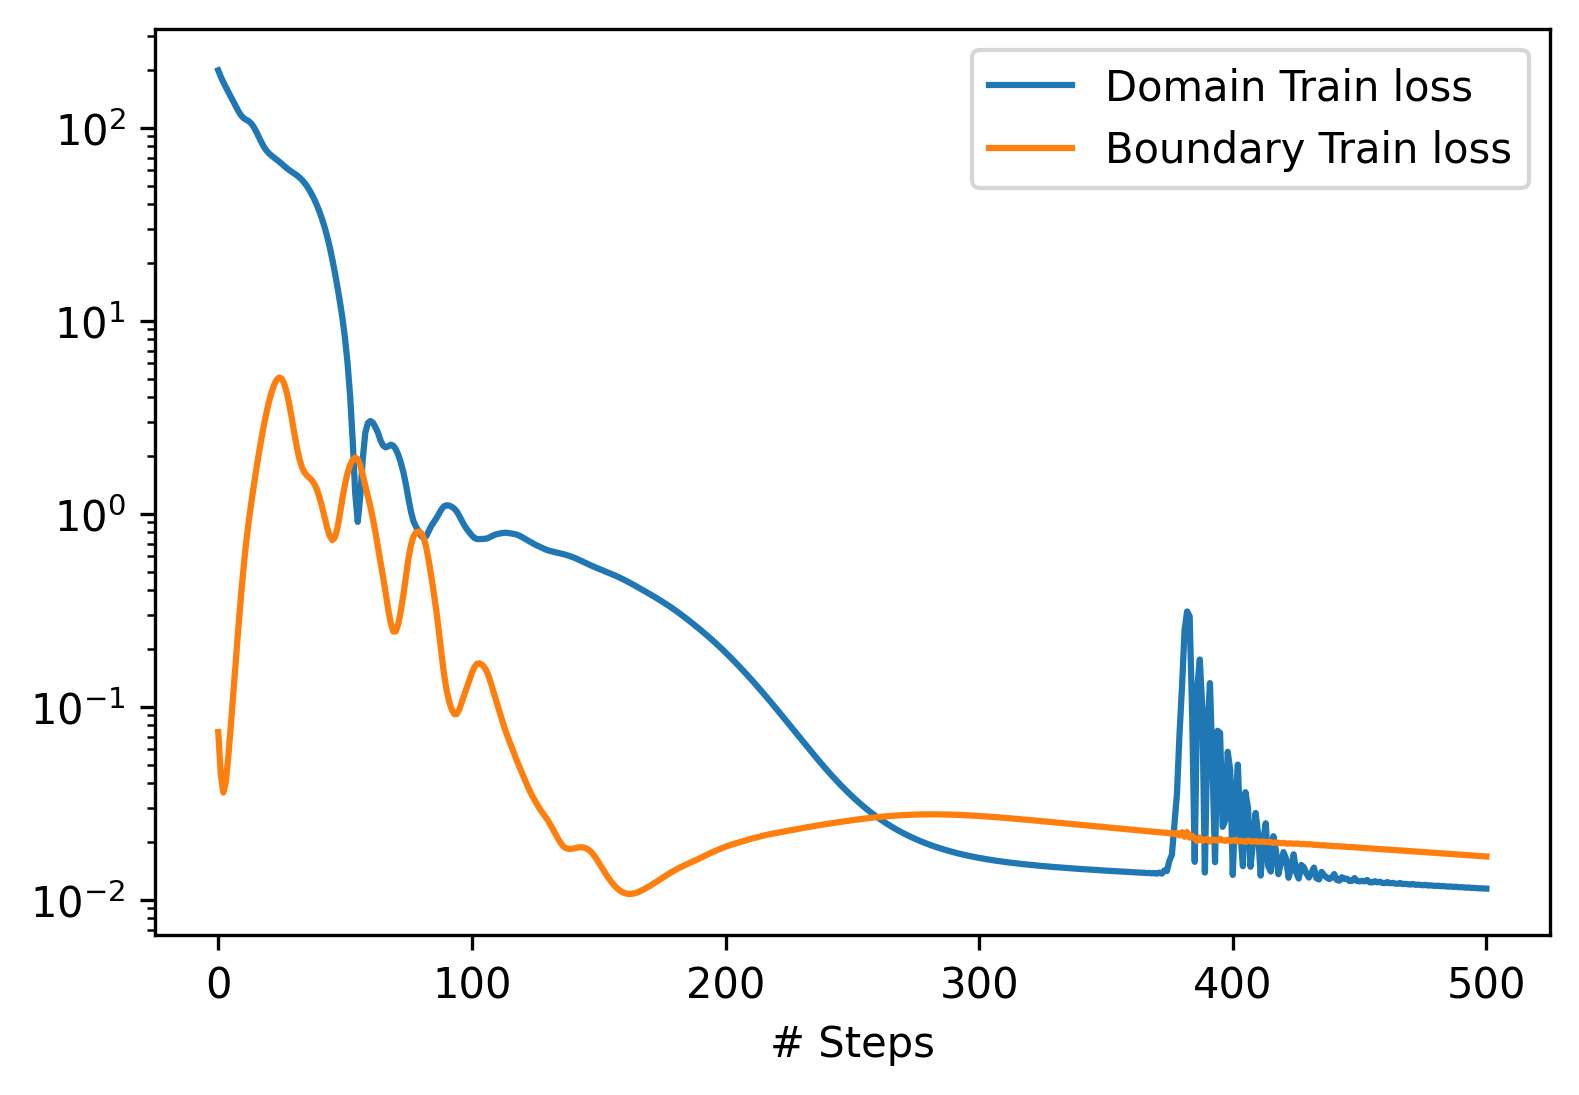

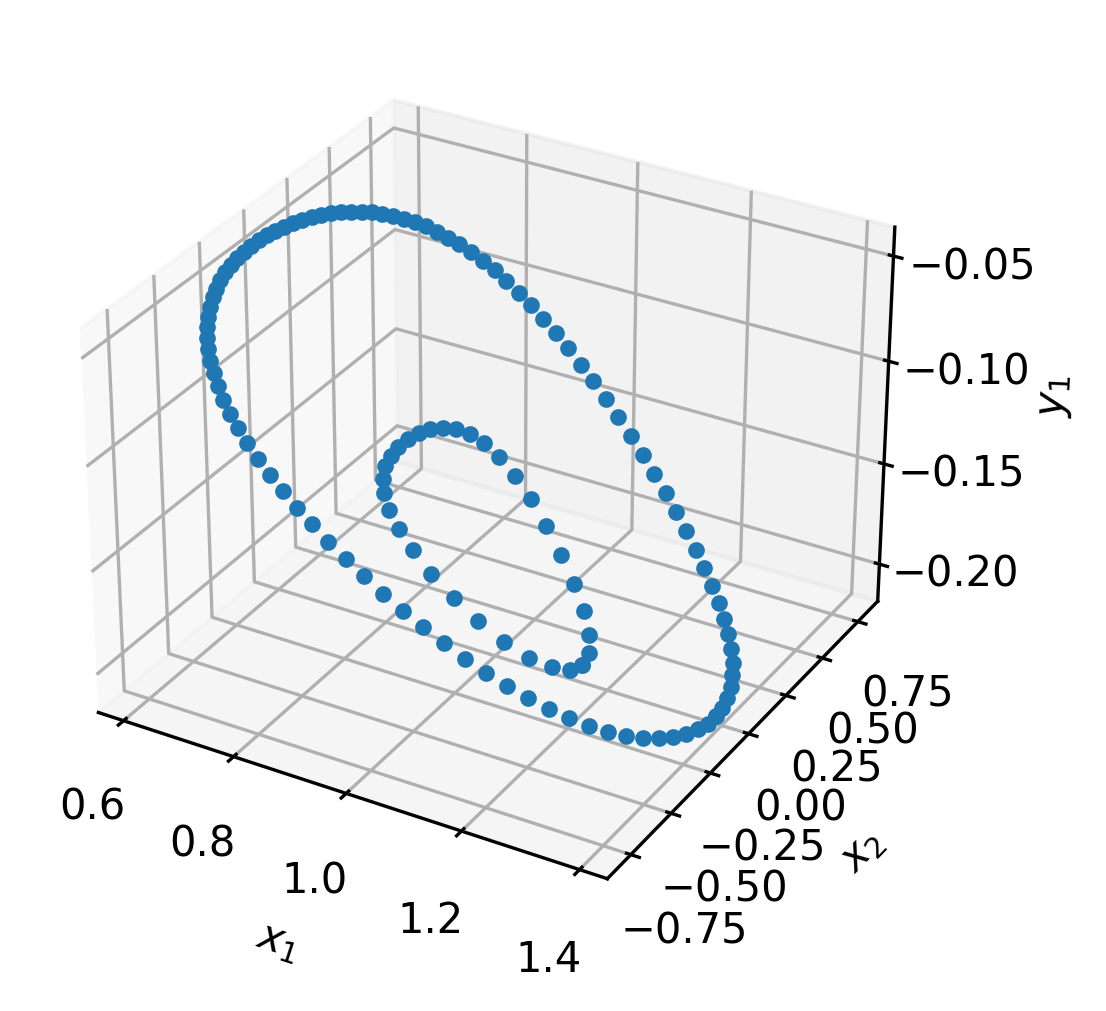

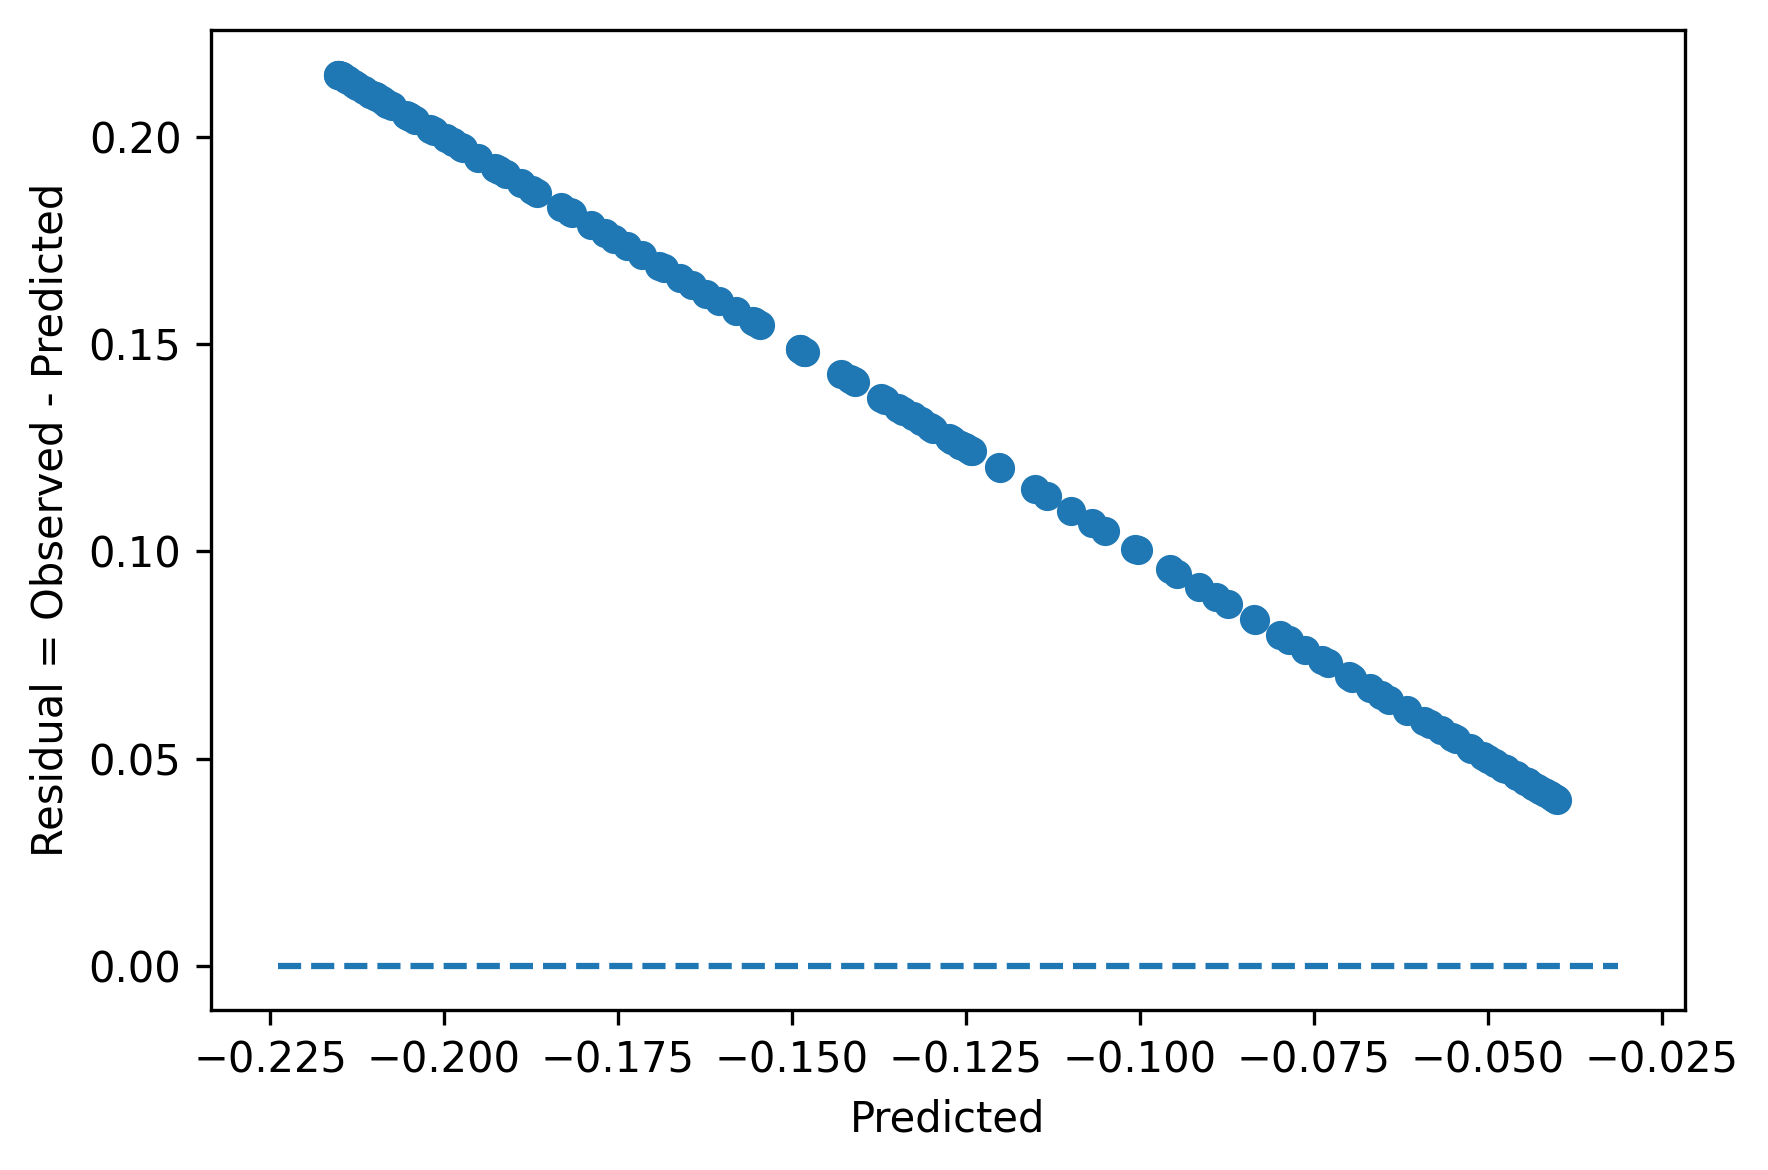

Accuracy
Mean residual: 0.058100767


In [7]:
#[0.02,0.007,0.002,0.0007,0.0002]
import os
DATE = "10132022"
CONFIG = "DoubleNullITER"
LR = 8e-3
DEPTH = 3
BREADTH = 20
run = "01_500Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"

PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"
# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN([2] + DEPTH * [BREADTH] + [1], AF, "Glorot normal")

model = dde.Model(data, net)
decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[100,10,1,1,
                    5,5,1,5,
                    1,5]  )


  loss_history, train_state = model.train(epochs=500, display_every = 1)
  dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')

# make mesh
nx = 201
ny = 201
zoom = ((1 + eps)-(1 - eps))*0.05
innerPoint = 1 - eps - zoom
outerPoint = 1 + eps + zoom
lowPoint   = -kappa * eps - zoom
highPoint  = kappa * eps + zoom
x, y = np.meshgrid(
    np.linspace(innerPoint, outerPoint, nx),
    np.linspace(lowPoint, highPoint, ny),
)
X = np.vstack((np.ravel(x), np.ravel(y))).T
output = model.predict(X)
GS = model.predict(X, operator=pde_solovev)
residual_psi = np.mean(np.absolute(GS))

print("Accuracy")
print("Mean residual:", residual_psi)

### Plotting

#### Before BFGS

(501, 501)


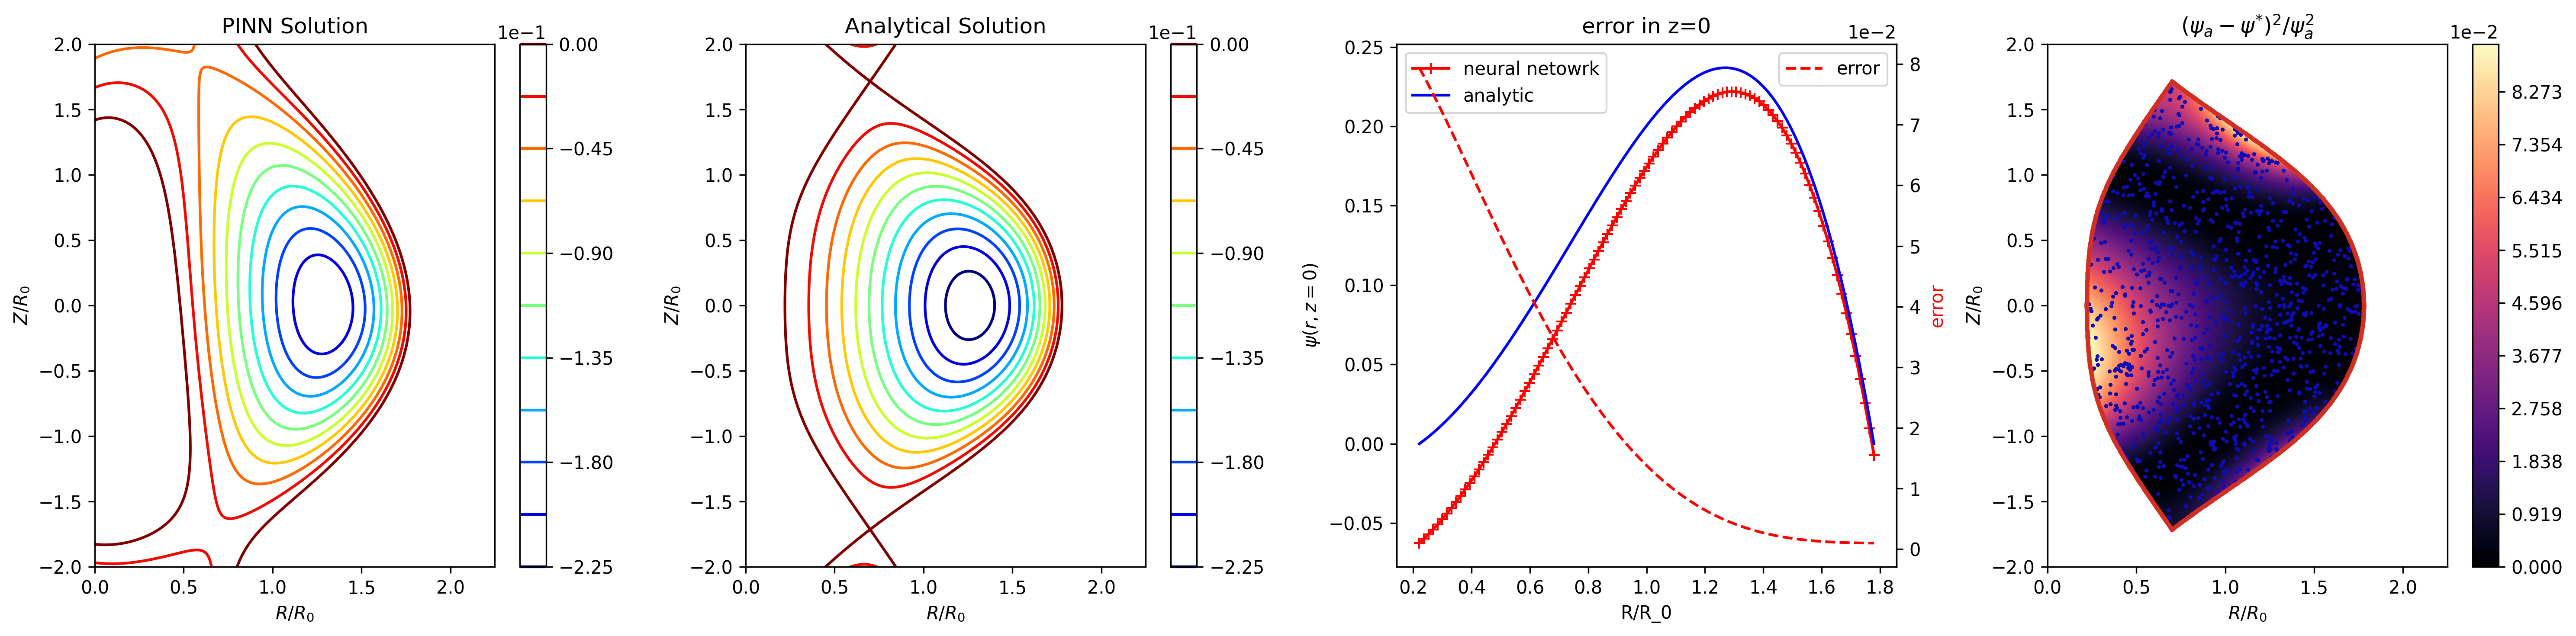

In [8]:
# Evaluation
from utils.utils import evaluate,evaluate_eq, relative_error_plot
from matplotlib.pyplot import colorbar, Normalize, show, subplots
from matplotlib.cm import ScalarMappable, jet, inferno
X_test = spatial_domain.random_points(333)

x,y,psi_pred,psi_true,error=evaluate(NSTX,model)
x_eq, psi_true_eq, psi_pred_eq, e_eq= evaluate_eq(NSTX,model)

# Plotting Setup
plt.rcParams['figure.dpi'] = 300
print(psi_pred.shape)
fig,axs=plt.subplots(1,4,figsize=(20,5))
ax1,ax2,ax3,ax4=axs[0],axs[1],axs[2],axs[3]
levels = np.linspace(min(psi_true.reshape(-1)),0,8)

# ColorMap setting
norm = Normalize(vmin=np.min(psi_pred), vmax=0)
cmap = jet

# Plot 1 - PINN Solution
cp = ax1.contour(x, y, psi_pred,norm=norm,cmap=cmap,levels=D)
# ax1.scatter(observe_x[:,0], observe_x[:,1], s = 2,c="black")
fig.colorbar(cp,ax=ax1).formatter.set_powerlimits((0, 0)) 
ax1.set_title('PINN Solution')
ax1.set_xlabel(r'$R/R_{0}$')
ax1.set_ylabel(r'$Z/R_{0}$')
ax1.axis(xmin=PLOT_PARAM["xmin"],xmax=PLOT_PARAM["xmax"],ymin=PLOT_PARAM["ymin"], ymax=PLOT_PARAM["ymax"])

# Plot 2 - Analytic Solution
cp = ax2.contour(x, y, psi_true,norm=norm,cmap=cmap,levels=D)
fig.colorbar(cp,ax=ax2).formatter.set_powerlimits((0, 0))
ax2.set_title('Analytical Solution')
ax2.set_xlabel(r'$R/R_{0}$')
ax2.set_ylabel(r'$Z/R_{0}$')
ax2.axis(xmin=PLOT_PARAM["xmin"],xmax=PLOT_PARAM["xmax"],ymin=PLOT_PARAM["ymin"], ymax=PLOT_PARAM["ymax"])

# Plot 3 - Equatorial Error
twin3 = ax3.twinx()
ax3.plot(x_eq, -psi_pred_eq,marker="+",color="red",label="neural netowrk")
ax3.plot(x_eq, -psi_true_eq,color="blue",label="analytic")
twin3.plot(x_eq, e_eq, color='red',linestyle='--',label="error")
twin3.yaxis.get_major_formatter().set_scientific(True)
ax3.set_title('error in z=0')
ax3.set_xlabel('R/R_0')
ax3.set_ylabel(r'$\psi(r,z=0)$')
ax3.legend(loc='upper left')
twin3.legend(loc='upper right')
twin3.set_ylabel('error', color='red')
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

# Plot 4 - Relative Error
fig, ax4 = relative_error_plot(fig,ax4,x,y,error,model,NSTX,DIVERTOR=True,v=v,X_test=X_test)
ax4.scatter(v[:,0],v[:,1], s = 2,c="#D12F24")
# ax4.set_title(r'$($\psi$_{n}-u^{*})^2/u_{a}^2$')
ax4.set_title(r'($\psi_{a}-\psi^{*})^2/\psi_{a}^2$')
ax4.set_xlabel(r'$R/R_{0}$')
ax4.set_ylabel(r'$Z/R_{0}$')
ax4.axis(xmin=PLOT_PARAM["xmin"],xmax=PLOT_PARAM["xmax"],ymin=PLOT_PARAM["ymin"], ymax=PLOT_PARAM["ymax"])

fig.tight_layout()
plt.savefig(f'./cefron/{CONFIG}/runs/{RUN_NAME}/analysis_before_BFGS.jpg')




#### After BFGS

Compiling model...
'compile' took 2.093179 s

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
500       [1.14e-03, 1.67e-02, 6.17e-04, 3.35e-03, 4.28e-04, 1.46e-02, 6.77e-04, 2.10e-06, 7.68e-04, 1.78e-03]    [5.88e-04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
510       [2.19e-03, 2.14e-02, 5.04e-04, 3.81e-03, 4.55e-04, 4.86e-03, 1.06e-03, 9.20e-05, 3.86e-04, 9.01e-05]                                                                                                                
520       [6.19e-03, 1.47e-02, 3.00e-05, 1.95e-03, 3.10e-04, 1.93e-03, 1.08e-04, 2.38e-05, 1.61e-03, 3.32e-04]                                                                                                                
530       [3.73e-03, 1.26e-02, 1.21e

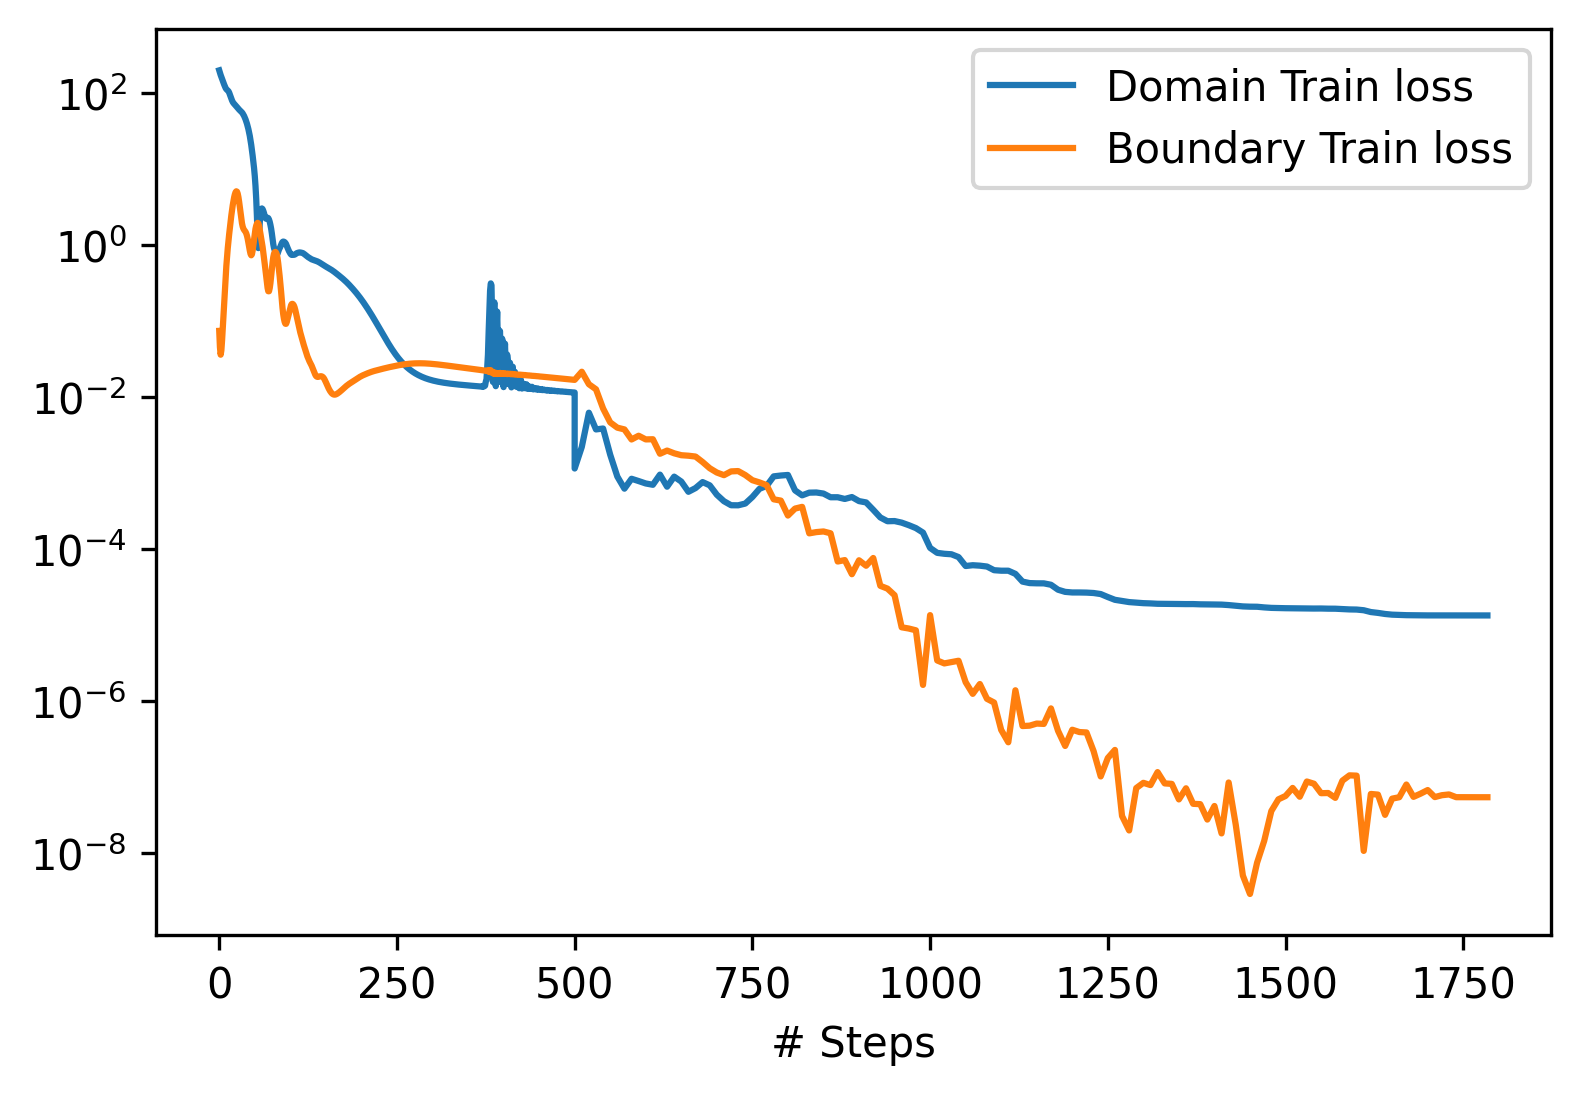

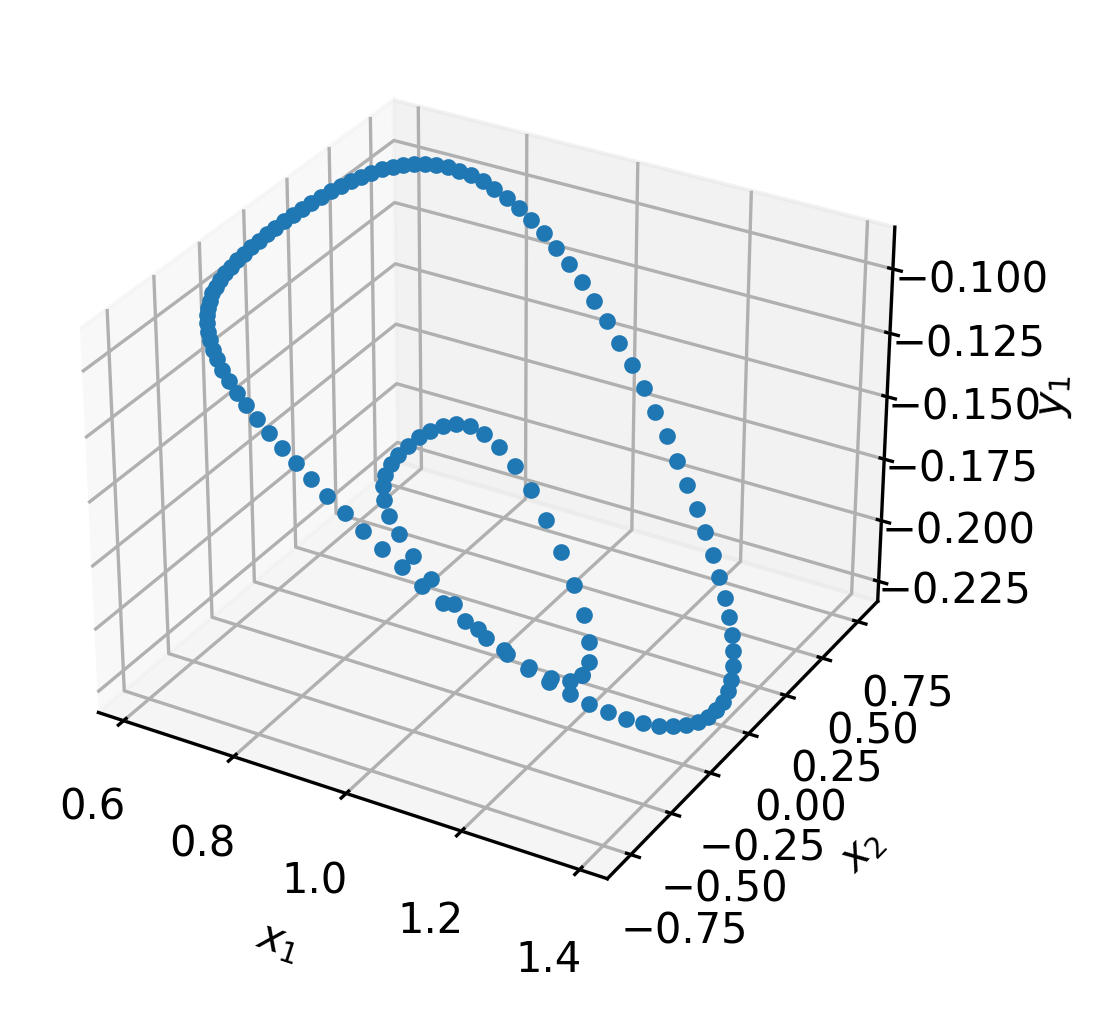

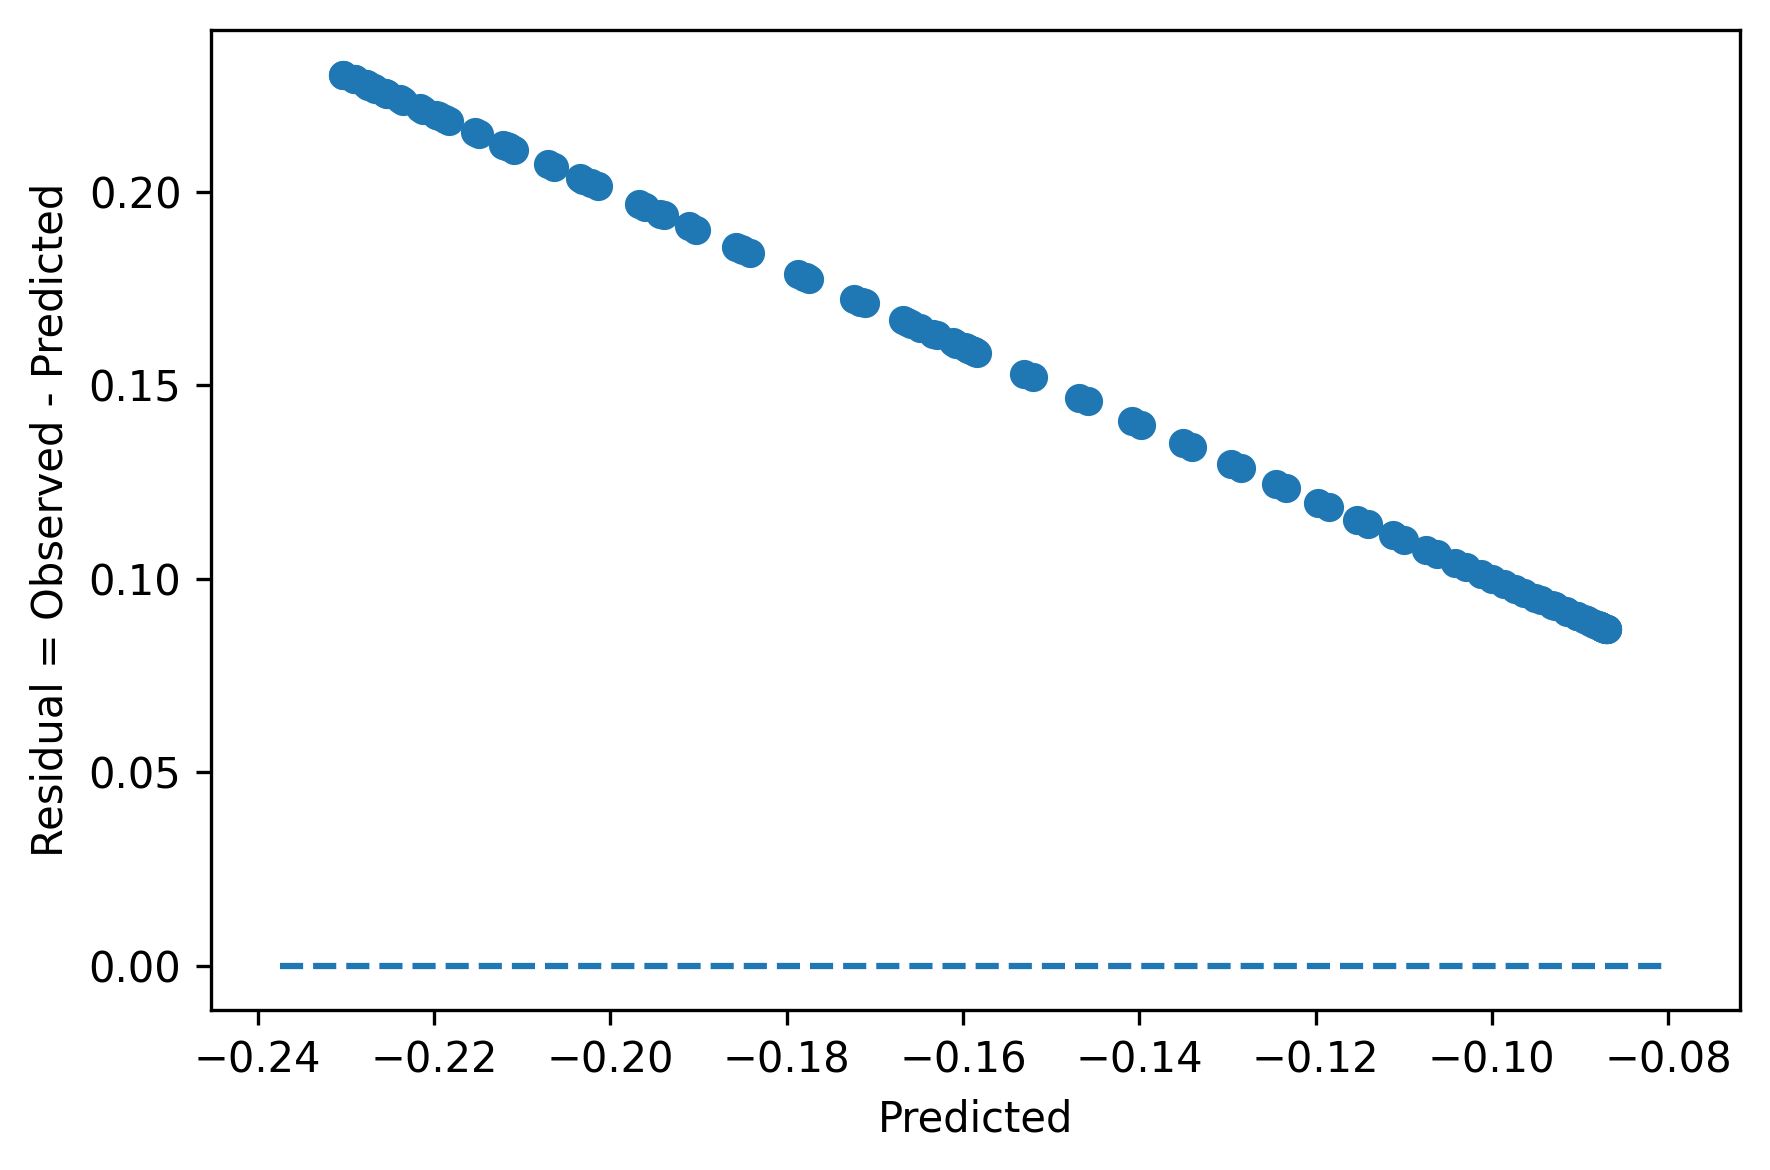

In [9]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    # PDE Loss, fluxloss, outer_curv, inner_curv,
    # high_sep_slop_r,high_sep_slop_z, inner_slop_z, low_sep_slop_r,
    # outer_slop_z,low_sep_slop_z
    # loss_weights=[10,1,1,1,
    #             5,5,1,5,
    #             1,5]
    # loss_weights=[100,1,1,1,
    #             10,10,1,10,
    #             1,10]
    # loss_weights=[10,1,10,10,
    #                 1,1,10,1,
    #                 10,1]
    loss_weights=[10,10,1,1,
                    10,10,1,10,
                    1,10]  
)
loss_history, train_state = model.train(epochs=1000, display_every = 10)
dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')


(501, 501)


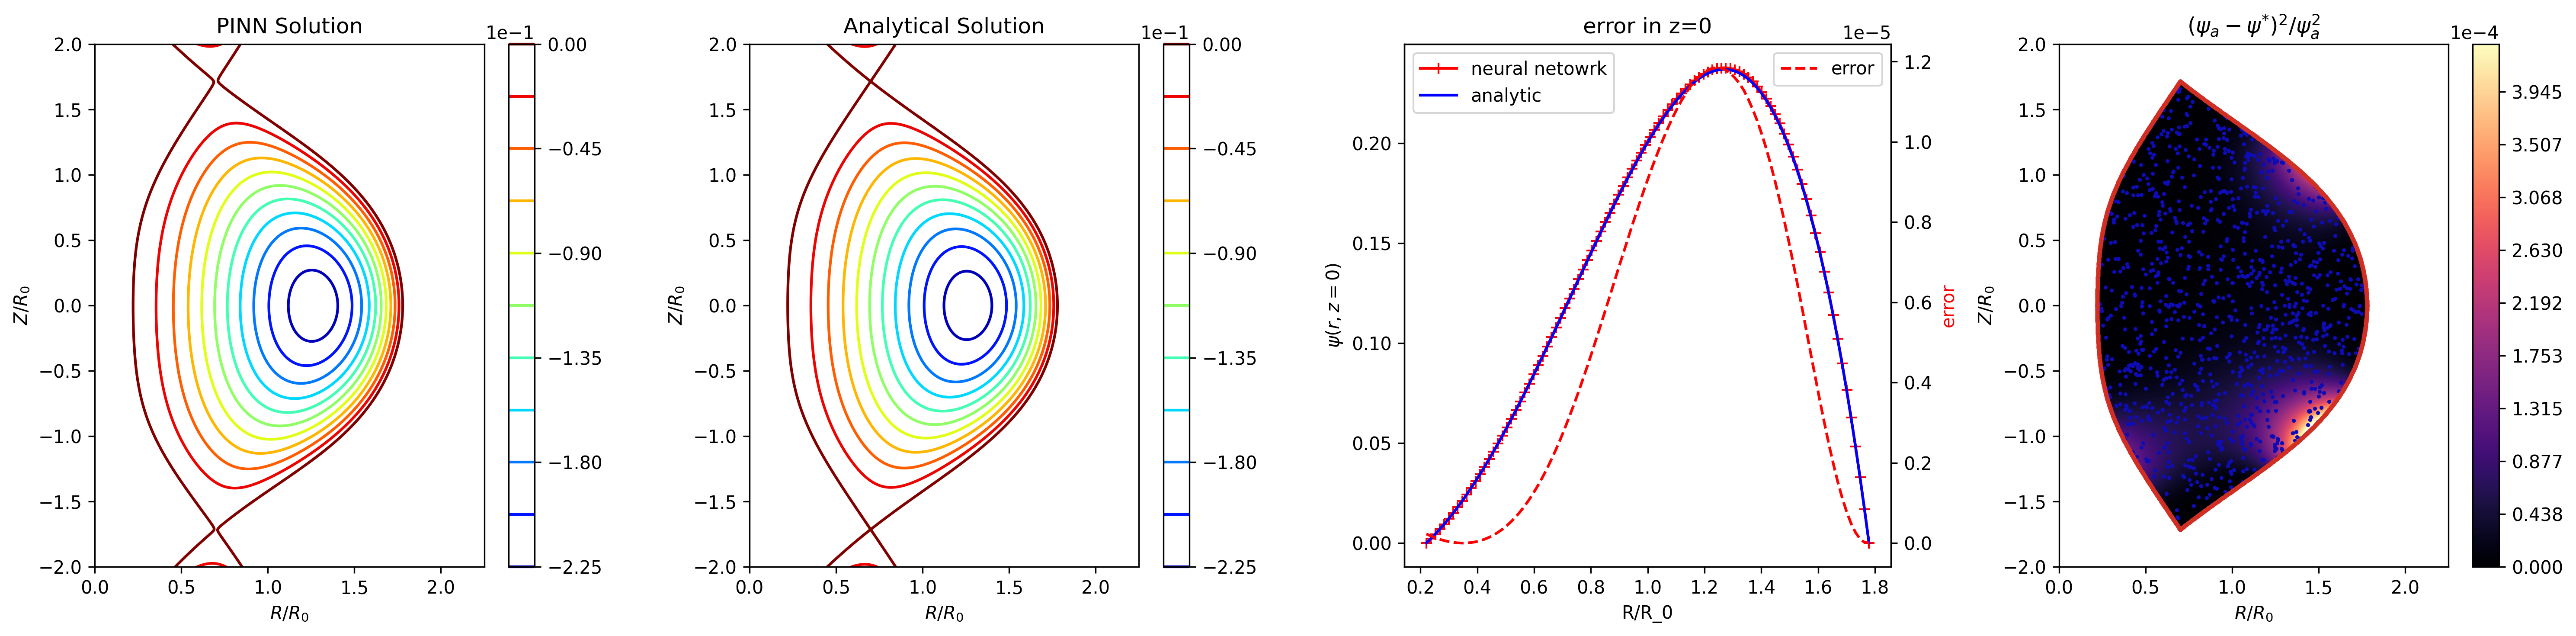

In [10]:
# Evaluation
from utils.utils import evaluate,evaluate_eq, relative_error_plot
from matplotlib.pyplot import colorbar, Normalize, show, subplots
from matplotlib.cm import ScalarMappable, jet, inferno

X_test = spatial_domain.random_points(333)

x,y,psi_pred,psi_true,error=evaluate(NSTX,model)
x_eq, psi_true_eq, psi_pred_eq, e_eq= evaluate_eq(NSTX,model)

# Plotting Setup
plt.rcParams['figure.dpi'] = 300
print(psi_pred.shape)
fig,axs=plt.subplots(1,4,figsize=(20,5))
ax1,ax2,ax3,ax4=axs[0],axs[1],axs[2],axs[3]
levels = np.linspace(min(psi_true.reshape(-1)),0,8)

# ColorMap setting
norm = Normalize(vmin=np.min(psi_pred), vmax=0)
cmap = jet

# Plot 1 - PINN Solution
cp = ax1.contour(x, y, psi_pred,norm=norm,cmap=cmap,levels=D)
# ax1.scatter(observe_x[:,0], observe_x[:,1], s = 2,c="black")
fig.colorbar(cp,ax=ax1).formatter.set_powerlimits((0, 0)) 
ax1.set_title('PINN Solution')
ax1.set_xlabel(r'$R/R_{0}$')
ax1.set_ylabel(r'$Z/R_{0}$')
ax1.axis(xmin=PLOT_PARAM["xmin"],xmax=PLOT_PARAM["xmax"],ymin=PLOT_PARAM["ymin"], ymax=PLOT_PARAM["ymax"])

# Plot 2 - Analytic Solution
cp = ax2.contour(x, y, psi_true,norm=norm,cmap=cmap,levels=D)
fig.colorbar(cp,ax=ax2).formatter.set_powerlimits((0, 0))
ax2.set_title('Analytical Solution')
ax2.set_xlabel(r'$R/R_{0}$')
ax2.set_ylabel(r'$Z/R_{0}$')
ax2.axis(xmin=PLOT_PARAM["xmin"],xmax=PLOT_PARAM["xmax"],ymin=PLOT_PARAM["ymin"], ymax=PLOT_PARAM["ymax"])

# Plot 3 - Equatorial Error
twin3 = ax3.twinx()
ax3.plot(x_eq, -psi_pred_eq,marker="+",color="red",label="neural netowrk")
ax3.plot(x_eq, -psi_true_eq,color="blue",label="analytic")
twin3.plot(x_eq, e_eq, color='red',linestyle='--',label="error")
twin3.yaxis.get_major_formatter().set_scientific(True)
ax3.set_title('error in z=0')
ax3.set_xlabel('R/R_0')
ax3.set_ylabel(r'$\psi(r,z=0)$')
ax3.legend(loc='upper left')
twin3.legend(loc='upper right')
twin3.set_ylabel('error', color='red')
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

# Plot 4 - Relative Error
fig, ax4 = relative_error_plot(fig,ax4,x,y,error,model,NSTX,DIVERTOR=True,v=v,X_test=X_test)
ax4.scatter(v[:,0],v[:,1], s = 2,c="#D12F24")
# ax4.set_title(r'$($\psi$_{n}-u^{*})^2/u_{a}^2$')
ax4.set_title(r'($\psi_{a}-\psi^{*})^2/\psi_{a}^2$')
ax4.set_xlabel(r'$R/R_{0}$')
ax4.set_ylabel(r'$Z/R_{0}$')
ax4.axis(xmin=PLOT_PARAM["xmin"],xmax=PLOT_PARAM["xmax"],ymin=PLOT_PARAM["ymin"], ymax=PLOT_PARAM["ymax"])

fig.tight_layout()
plt.savefig(f'./cefron/{CONFIG}/runs/{RUN_NAME}/analysis_after_BFGS.jpg')







